In [1]:
import time

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# 自作関数
from dataload.data_load import data_load
from func.my_func import *

In [2]:
keio_df = pd.read_csv('../../../野球部データ収集/keio_data/keio.csv', parse_dates=[1])
use_feature_df = keio_df[['UserID', 'TargetDate', 'Score', 'DiffRestHrValue', 'DiffWakedHrValue',
        'StressCount', 'DeepSleepRate', 'LowActivityHourws']]

answer_df = pd.read_csv('../../../野球部データ収集/keio_data/keio_answer_data.csv', parse_dates=[1])
category = pd.read_csv('../../../野球部データ収集/keio_data/category.csv', encoding='shift-jis')
answer_df = answer_df.merge(category)

def create_user_feature(user_id):
    output_df = use_feature_df[use_feature_df['UserID'] == user_id].reset_index(drop=True)
    output_df['TargetDate'] = output_df['TargetDate'].dt.date
    return output_df

def create_y(user_id):
    _piv_df = answer_df[answer_df['UserID'] == user_id].pivot_table(
        values='value',
        index='TargetDate',
        columns='category'
    ).reset_index()
    _piv_df['TargetDate'] = _piv_df['TargetDate'].dt.date
    _piv_df = _piv_df.drop(['体温', '朝食'], axis=1)
    _piv_df['mean'] = _piv_df.mean(axis=1)
    _piv_df['y'] = _piv_df['mean'].apply(lambda x: 1 if x >= _piv_df['mean'].mean()+_piv_df['mean'].std() else 0)
    for i in ['下肢の状態',	'肘の状態', '肩の状態']:
        _piv_df[f'y_{i}'] = _piv_df[i].apply(lambda x: int(x > 3))
    return _piv_df


## MTS

In [3]:
# users = keio_df['UserID'].unique()
users = [
    # 1504, 
    1505, 
1755, 
1781, 
1774, 
1773
]
user_id = users[0]

1505


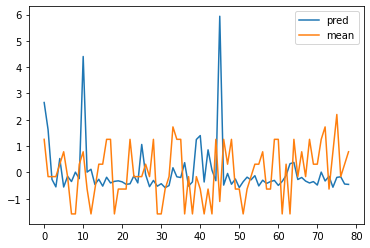

1755


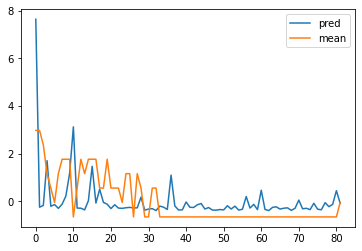

1781


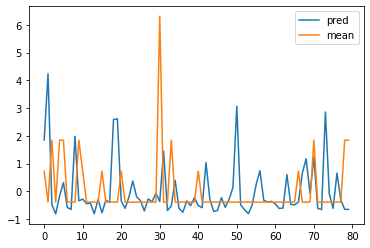

1774


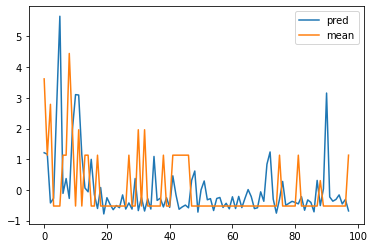

1773


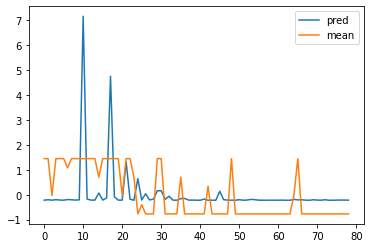

,mean
1505,-0.03826
1755,0.366065
1781,-0.073235
1774,0.052289
1773,0.259296


In [12]:
score_df = pd.DataFrame(index=users, columns=['mean'])
for user_id in users:
    print(user_id)
    _X = create_user_feature(user_id).drop(['UserID', 'Score'], axis=1)
    _y = create_y(user_id)
    df = pd.merge(_X, _y, how='inner', on='TargetDate')
    _X = df[['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                'DeepSleepRate', 'LowActivityHourws']]
    _X = _X.fillna(_X.mean())
    for n in range(7, len(df)):
        X = _X.iloc[:n]
        y = _y['y'].iloc[:n]
        X_test = _X.iloc[[n]]
        # 正常データのみを使用して標準化
        scaler = StandardScaler()
        if (y == 0).sum() > 3:
            scaler.fit(X[y == 0])
            normal_Z = scaler.transform(X[y == 0])
            if len(X[y == 1]) > 0:
                anomaly_Z = scaler.transform(X[y == 1])    # 正常データのみを使用して共分散行列を計算
            inv_C = inv_cov(normal_Z)
            # 異常データと直交表を用いてSN比を計算
            #L8直行表
            l8 = np.array([
                [1,1,1,1,1,1,1],
                [1,1,1,2,2,2,2],
                [1,2,2,1,1,2,2],
                [1,2,2,2,2,1,1],
                [2,1,2,1,2,1,2],
                [2,1,2,2,1,2,1],
                [2,2,1,1,2,2,1],
                [2,2,1,2,1,1,2]
                ])
            l8 = (l8 == 1)
            l8 = l8[:, :len(X.columns)]

            if len(X[y == 1]) > 0:
                #異常データのマハラノビス距離
                result = np.zeros((l8.shape[0], anomaly_Z.shape[0]))
                for i, l8_row in enumerate(l8):
                    result[i] = cal_MD(anomaly_Z[:, l8_row], inv_C[l8_row][:,l8_row])

                #SN比
                sn = np.zeros(l8.shape[0])
                for idx, row in enumerate(result):
                    sum_MD = 0
                    for i in range(len(row)):
                        sum_MD += 1 / row[i]
                    sn[idx] = -10 * math.log10(sum_MD / len(row))
                    
                # SN比を利用し，不要と思われる変数を削除する
                #変数選択
                df_sn = pd.DataFrame(index=X.columns, columns=['SN比','残す'])
                for i, clm in enumerate(X.columns):
                    df_sn.loc[df_sn.index == clm, 'SN比'] = sum(sn[l8.T[i]]) - sum(sn[~l8.T[i]])
                    df_sn.loc[df_sn.index == clm, '残す'] = sum(sn[l8.T[i]]) - sum(sn[~l8.T[i]]) > 0
                #使用した変数を保存
                select_columns = df_sn[df_sn['残す']].index
                
                if len(select_columns) > 1:
                    # 選択変数でのスケーラーと共分散行列を計算
                    result_scaler = StandardScaler()
                    result_scaler.fit(X[select_columns][y == 0])
                    result_Z = result_scaler.transform(X[select_columns][y == 0])
                    result_inv_C = inv_cov(result_Z)
                # 選択された変数が一つ以下の場合はその変数を正常データの平均と標準偏差で標準化してそれの二乗を異常値とする
                else:
                    select_columns = df_sn['SN比'].astype(float).idxmax()
                    result_scaler = X[select_columns][y == 0].mean()
                    result_inv_C = X[select_columns][y == 0].std()
                df.loc[n, 'pred'] = list(predict_MD(X_test, result_scaler, result_inv_C, select_columns))[0]
            else:
                result_scaler = scaler
                result_inv_C = inv_C
                select_columns = X.columns
                df.loc[n, 'pred'] = list(predict_MD(X_test, result_scaler, result_inv_C, select_columns))[0]
        else:
            scaler.fit(X)
            Z = scaler.transform(X)
            inv_C = inv_cov(Z)
            _Z = scaler.transform(X_test)
            md = np.dot(_Z, inv_C)
            MD = np.dot(md, _Z.T) / _Z.shape[1]
            df.loc[n, 'pred'] = MD[0][0]
    scaler = StandardScaler()
    plt.plot(scaler.fit_transform(df[['pred', 'mean']].iloc[7:]))
    plt.legend(['pred', 'mean'])
    plt.show()
    score_df.loc[user_id] = df[['pred', 'mean']].iloc[7:].corr().iloc[0][1]
score_df

In [13]:
score_df.mean()

mean    0.113231
dtype: float64